# 2.3: 1D Burgers Equation - PyTorch Implementation

This notebook solves the 1D viscous Burgers equation using pure PyTorch instead of DeepXDE.
The Burgers equation is a fundamental nonlinear PDE that exhibits rich behavior including shock formation.

### Problem Definition:
- **PDE**: $\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$
- **Domain**: $x \in [-1, 1]$, $t \in [0, 1]$
- **Initial Condition**: $u(x, 0) = -\sin(\pi x)$
- **Boundary Conditions**:
    - $u(-1, t) = 0$
    - $u(1, t) = 0$
- **Kinematic Viscosity**: $\nu = 0.01/\pi$

This is a challenging nonlinear problem that tests the capability of PINNs to handle complex dynamics.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set device and style
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
sns.set_style("whitegrid")

# Problem parameters
nu = 0.01 / np.pi  # Kinematic viscosity
print(f"Kinematic viscosity ν = {nu:.6f}")

Using device: cuda
Kinematic viscosity ν = 0.003183


## 1. Neural Network Architecture

For nonlinear problems like Burgers equation, we often need deeper or wider networks to capture the complex dynamics.

In [9]:
class BurgersPINN(nn.Module):
    """Physics-Informed Neural Network for Burgers Equation"""
    
    def __init__(self, hidden_dim=20, num_layers=8):
        super(BurgersPINN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(2, hidden_dim))  # Input: (x, t)
        
        for _ in range(num_layers):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 1))  # Output: u(x,t)
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights using Xavier initialization
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)

# Create model
model = BurgersPINN(hidden_dim=20, num_layers=8).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model depth: {len([m for m in model.modules() if isinstance(m, nn.Linear)])} layers")

Model parameters: 3441
Model depth: 10 layers


## 2. Domain Sampling Functions

In [10]:
def sample_domain_points(num_points, device=device):
    """Sample points from the interior domain"""
    x = torch.rand(num_points, 1, device=device) * 2 - 1  # x ∈ [-1, 1]
    t = torch.rand(num_points, 1, device=device)          # t ∈ [0, 1]
    return torch.cat([x, t], dim=1)

def sample_boundary_points(num_points, device=device):
    """Sample points from spatial boundaries (x=-1 and x=1)"""
    t = torch.rand(num_points, 1, device=device)  # t ∈ [0, 1]
    
    # Left boundary: x = -1
    x_left = torch.full((num_points//2, 1), -1.0, device=device)
    t_left = t[:num_points//2]
    left_boundary = torch.cat([x_left, t_left], dim=1)
    
    # Right boundary: x = 1
    x_right = torch.full((num_points//2, 1), 1.0, device=device)
    t_right = t[num_points//2:num_points//2 + num_points//2]
    right_boundary = torch.cat([x_right, t_right], dim=1)
    
    return torch.cat([left_boundary, right_boundary], dim=0)

def sample_initial_points(num_points, device=device):
    """Sample points from initial condition (t=0)"""
    x = torch.rand(num_points, 1, device=device) * 2 - 1  # x ∈ [-1, 1]
    t = torch.zeros(num_points, 1, device=device)         # t = 0
    return torch.cat([x, t], dim=1)

# Sample points (more points needed for nonlinear problems)
num_domain = 20000
num_boundary = 100
num_initial = 250

domain_points = sample_domain_points(num_domain, device)
boundary_points = sample_boundary_points(num_boundary, device)
initial_points = sample_initial_points(num_initial, device)

print(f"Domain points: {domain_points.shape}")
print(f"Boundary points: {boundary_points.shape}")
print(f"Initial points: {initial_points.shape}")
print(f"Total training points: {domain_points.shape[0] + boundary_points.shape[0] + initial_points.shape[0]}")

Domain points: torch.Size([20000, 2])
Boundary points: torch.Size([100, 2])
Initial points: torch.Size([250, 2])
Total training points: 20350


## 3. Automatic Differentiation Utilities

In [11]:
def compute_derivatives(u, points):
    """Compute partial derivatives of u with respect to x and t
    
    Args:
        u: Network output u(x,t)
        points: Input points [x, t]
    
    Returns:
        u_t: ∂u/∂t
        u_x: ∂u/∂x
        u_xx: ∂²u/∂x²
    """
    # First derivatives
    grad = torch.autograd.grad(
        outputs=u,
        inputs=points,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    u_x = grad[:, 0:1]  # ∂u/∂x
    u_t = grad[:, 1:2]  # ∂u/∂t
    
    # Second derivative ∂²u/∂x²
    u_xx = torch.autograd.grad(
        outputs=u_x,
        inputs=points,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0][:, 0:1]
    
    return u_t, u_x, u_xx

## 4. Problem Definition Functions

In [12]:
def initial_condition(points):
    """Initial condition: u(x,0) = -sin(πx)"""
    x = points[:, 0:1]
    return -torch.sin(np.pi * x)

def boundary_condition(points):
    """Boundary condition: u(±1,t) = 0"""
    return torch.zeros(points.shape[0], 1, device=points.device)

# Test initial condition
test_x = torch.tensor([[-1.0, 0.0], [0.0, 0.0], [1.0, 0.0]], device=device)
ic_test = initial_condition(test_x)
print(f"Initial condition test:")
print(f"  u(-1, 0) = {ic_test[0].item():.6f}")
print(f"  u(0, 0) = {ic_test[1].item():.6f}")
print(f"  u(1, 0) = {ic_test[2].item():.6f}")

Initial condition test:
  u(-1, 0) = -0.000000
  u(0, 0) = -0.000000
  u(1, 0) = 0.000000


## 5. Loss Functions

The Burgers equation is nonlinear due to the advection term $u\frac{\partial u}{\partial x}$.

In [13]:
def compute_losses(model, domain_points, boundary_points, initial_points):
    """Compute all loss components for the Burgers equation"""
    
    # Enable gradients for domain points
    domain_points.requires_grad_(True)
    
    # 1. PDE Loss: ∂u/∂t + u∂u/∂x - ν∇²u = 0
    u_domain = model(domain_points)
    u_t, u_x, u_xx = compute_derivatives(u_domain, domain_points)
    
    # Burgers equation residual (nonlinear term: u * u_x)
    pde_residual = u_t + u_domain * u_x - nu * u_xx
    loss_pde = torch.mean(pde_residual**2)
    
    # 2. Boundary Loss: u(±1,t) = 0
    u_boundary = model(boundary_points)
    bc_target = boundary_condition(boundary_points)
    loss_boundary = torch.mean((u_boundary - bc_target)**2)
    
    # 3. Initial Condition Loss: u(x,0) = -sin(πx)
    u_initial = model(initial_points)
    ic_target = initial_condition(initial_points)
    loss_initial = torch.mean((u_initial - ic_target)**2)
    
    # Total loss with weighting
    total_loss = loss_pde + loss_boundary + loss_initial
    
    return {
        'total': total_loss,
        'pde': loss_pde,
        'boundary': loss_boundary,
        'initial': loss_initial
    }

# Test loss computation
losses = compute_losses(model, domain_points, boundary_points, initial_points)
print("Initial losses:")
for key, value in losses.items():
    print(f"  {key}: {value.item():.6f}")

Initial losses:
  total: 0.447320
  pde: 0.001675
  boundary: 0.016524
  initial: 0.429121


## 6. Training with Adaptive Learning Rate

Nonlinear problems often benefit from adaptive learning rates and longer training.

In [14]:
def train_model(model, domain_points, boundary_points, initial_points, 
                epochs=30000, lr=1e-3, print_every=2000):
    """Train the PINN model with learning rate scheduling"""
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
    loss_history = []
    
    print(f"Starting training for {epochs} epochs...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Compute losses
        losses = compute_losses(model, domain_points, boundary_points, initial_points)
        total_loss = losses['total']
        
        # Backward pass
        total_loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        # Record losses
        loss_history.append({
            'epoch': epoch,
            'total': total_loss.item(),
            'pde': losses['pde'].item(),
            'boundary': losses['boundary'].item(),
            'initial': losses['initial'].item(),
            'lr': optimizer.param_groups[0]['lr']
        })
        
        # Print progress
        if (epoch + 1) % print_every == 0:
            elapsed_time = time.time() - start_time
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:5d}/{epochs} | "
                  f"Total: {total_loss.item():.3e} | "
                  f"PDE: {losses['pde'].item():.3e} | "
                  f"BC: {losses['boundary'].item():.3e} | "
                  f"IC: {losses['initial'].item():.3e} | "
                  f"LR: {current_lr:.1e} | "
                  f"Time: {elapsed_time:.1f}s")
            start_time = time.time()
    
    return loss_history

# Train the model
print("Training Burgers equation PINN...")
loss_history = train_model(model, domain_points, boundary_points, initial_points, 
                          epochs=30000, lr=1e-3, print_every=2000)

Training Burgers equation PINN...
Starting training for 30000 epochs...
Epoch  2000/30000 | Total: 1.632e-02 | PDE: 9.774e-03 | BC: 2.043e-04 | IC: 6.339e-03 | LR: 1.0e-03 | Time: 37.6s
Epoch  4000/30000 | Total: 3.151e-03 | PDE: 2.079e-03 | BC: 2.325e-05 | IC: 1.049e-03 | LR: 1.0e-03 | Time: 36.3s
Epoch  6000/30000 | Total: 2.611e-03 | PDE: 2.229e-03 | BC: 5.005e-05 | IC: 3.320e-04 | LR: 1.0e-03 | Time: 36.1s
Epoch  8000/30000 | Total: 1.283e-03 | PDE: 1.112e-03 | BC: 2.094e-05 | IC: 1.498e-04 | LR: 1.0e-03 | Time: 36.0s
Epoch 10000/30000 | Total: 3.361e-04 | PDE: 2.448e-04 | BC: 1.192e-05 | IC: 7.934e-05 | LR: 9.0e-04 | Time: 37.2s
Epoch 12000/30000 | Total: 1.533e-03 | PDE: 1.456e-03 | BC: 2.781e-05 | IC: 4.927e-05 | LR: 9.0e-04 | Time: 36.0s
Epoch 14000/30000 | Total: 1.779e-04 | PDE: 1.387e-04 | BC: 3.787e-06 | IC: 3.544e-05 | LR: 9.0e-04 | Time: 35.7s
Epoch 16000/30000 | Total: 5.521e-03 | PDE: 2.777e-03 | BC: 1.406e-03 | IC: 1.338e-03 | LR: 9.0e-04 | Time: 35.8s
Epoch 18000/3000

## 7. Visualization and Analysis

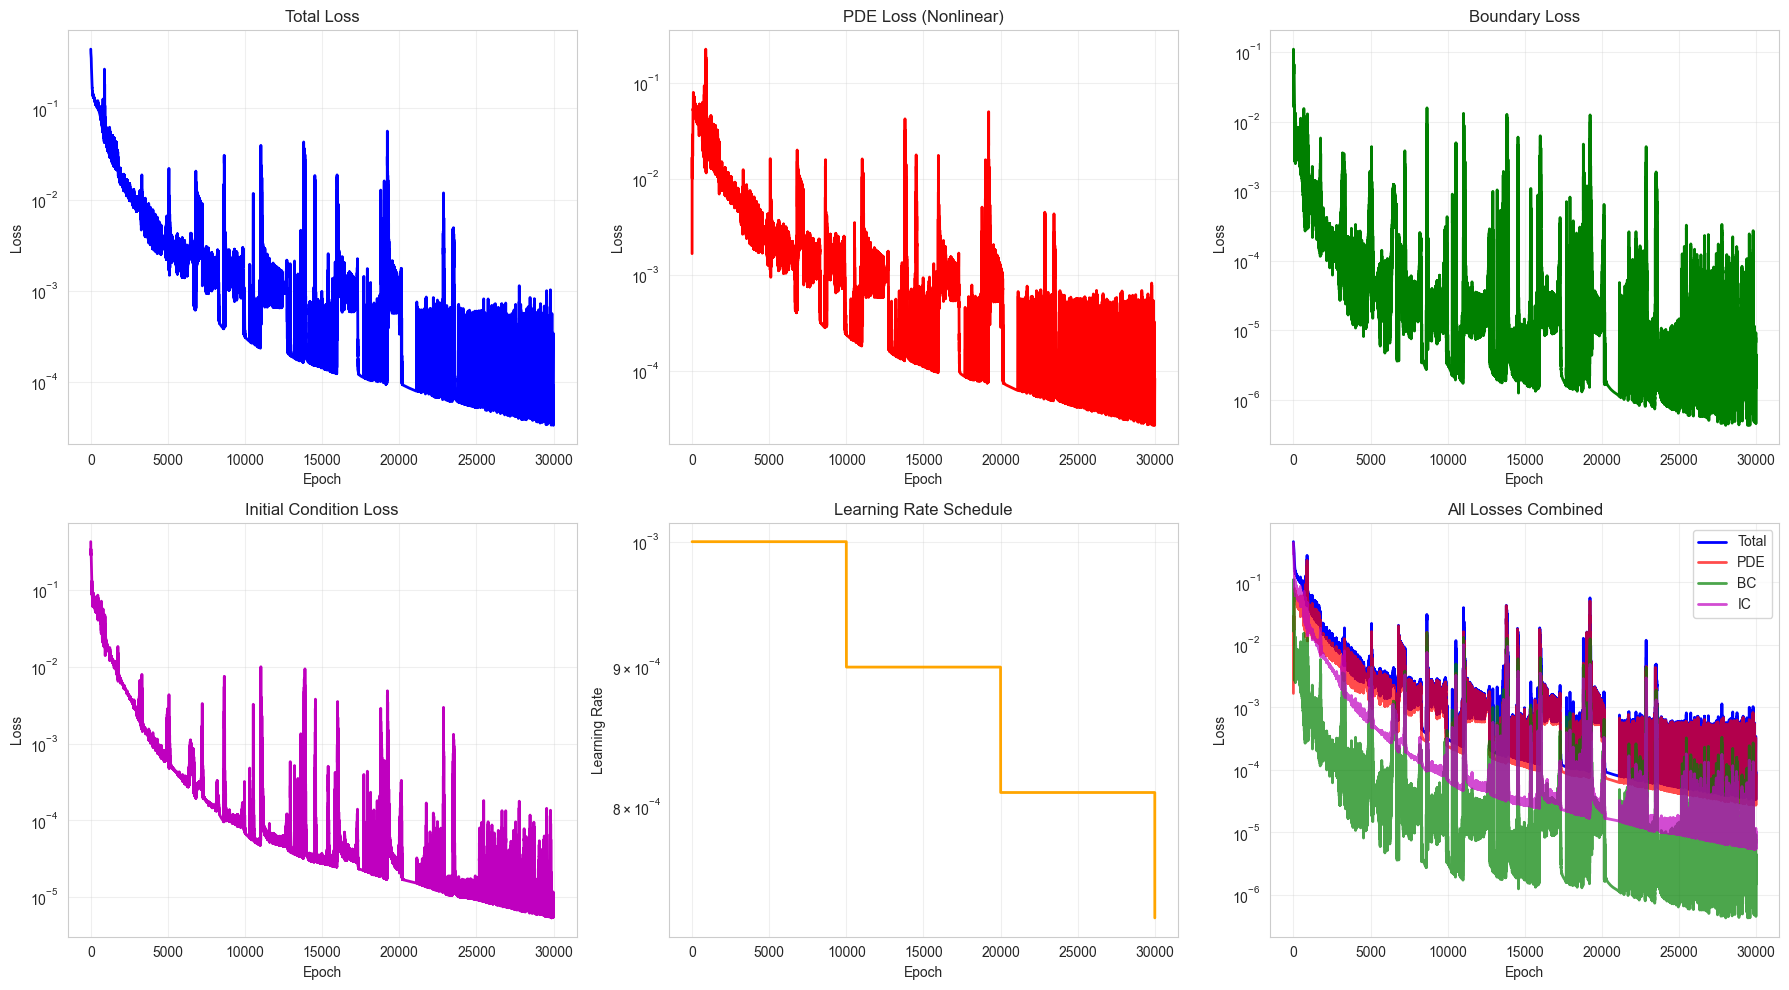

In [15]:
def plot_loss_history(loss_history):
    """Plot training loss history with learning rate"""
    epochs = [h['epoch'] for h in loss_history]
    total_losses = [h['total'] for h in loss_history]
    pde_losses = [h['pde'] for h in loss_history]
    boundary_losses = [h['boundary'] for h in loss_history]
    initial_losses = [h['initial'] for h in loss_history]
    learning_rates = [h['lr'] for h in loss_history]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss components
    axes[0, 0].plot(epochs, total_losses, 'b-', linewidth=2)
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(epochs, pde_losses, 'r-', linewidth=2)
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_title('PDE Loss (Nonlinear)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[0, 2].plot(epochs, boundary_losses, 'g-', linewidth=2)
    axes[0, 2].set_yscale('log')
    axes[0, 2].set_title('Boundary Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].grid(True, alpha=0.3)
    
    axes[1, 0].plot(epochs, initial_losses, 'm-', linewidth=2)
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Initial Condition Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(epochs, learning_rates, 'orange', linewidth=2)
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Combined loss plot
    axes[1, 2].plot(epochs, total_losses, 'b-', linewidth=2, label='Total')
    axes[1, 2].plot(epochs, pde_losses, 'r-', linewidth=2, alpha=0.7, label='PDE')
    axes[1, 2].plot(epochs, boundary_losses, 'g-', linewidth=2, alpha=0.7, label='BC')
    axes[1, 2].plot(epochs, initial_losses, 'm-', linewidth=2, alpha=0.7, label='IC')
    axes[1, 2].set_yscale('log')
    axes[1, 2].set_title('All Losses Combined')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot loss history
plot_loss_history(loss_history)

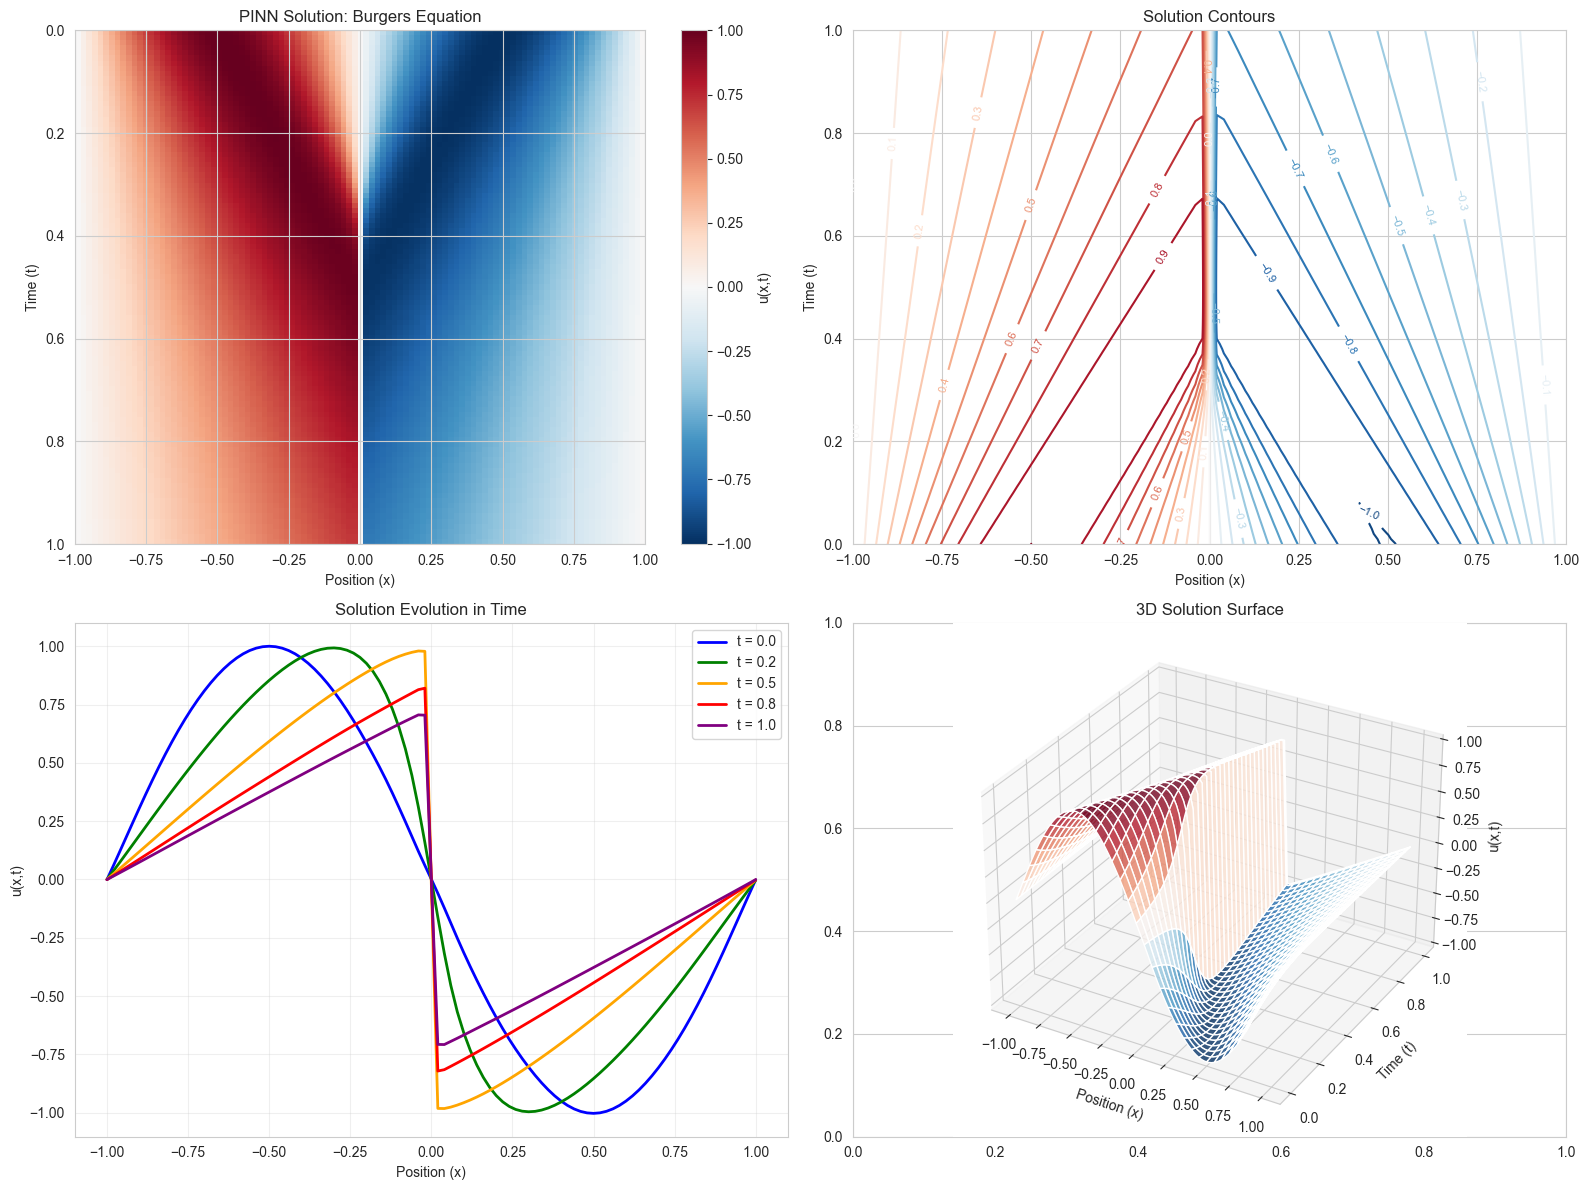

In [16]:
def visualize_solution(model, resolution=101):
    """Visualize the Burgers equation solution"""
    model.eval()
    
    # Create grid for visualization
    x = torch.linspace(-1, 1, resolution)
    t = torch.linspace(0, 1, resolution)
    X, T = torch.meshgrid(x, t, indexing='ij')
    
    # Flatten for model prediction
    xt_test = torch.stack([X.flatten(), T.flatten()], dim=1).to(device)
    
    # Predict solution
    with torch.no_grad():
        u_pred = model(xt_test).cpu()
    U_pred = u_pred.reshape(resolution, resolution)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Solution heatmap
    X_np, T_np = X.numpy(), T.numpy()
    U_pred_np = U_pred.numpy()
    
    im1 = axes[0, 0].imshow(U_pred_np.T, extent=[-1, 1, 1, 0], aspect='auto', cmap='RdBu_r')
    axes[0, 0].set_title('PINN Solution: Burgers Equation')
    axes[0, 0].set_xlabel('Position (x)')
    axes[0, 0].set_ylabel('Time (t)')
    plt.colorbar(im1, ax=axes[0, 0], label='u(x,t)')
    
    # Contour plot
    contour = axes[0, 1].contour(X_np, T_np, U_pred_np, levels=20, cmap='RdBu_r')
    axes[0, 1].clabel(contour, inline=True, fontsize=8)
    axes[0, 1].set_title('Solution Contours')
    axes[0, 1].set_xlabel('Position (x)')
    axes[0, 1].set_ylabel('Time (t)')
    
    # Solution at different times
    time_slices = [0.0, 0.2, 0.5, 0.8, 1.0]
    colors = ['blue', 'green', 'orange', 'red', 'purple']
    
    for i, (t_val, color) in enumerate(zip(time_slices, colors)):
        t_idx = int(t_val * (resolution - 1))
        axes[1, 0].plot(x.numpy(), U_pred_np[:, t_idx], color=color, linewidth=2, 
                       label=f't = {t_val:.1f}')
    
    axes[1, 0].set_title('Solution Evolution in Time')
    axes[1, 0].set_xlabel('Position (x)')
    axes[1, 0].set_ylabel('u(x,t)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 3D surface plot
    ax_3d = fig.add_subplot(2, 2, 4, projection='3d')
    surf = ax_3d.plot_surface(X_np, T_np, U_pred_np, cmap='RdBu_r', alpha=0.8)
    ax_3d.set_title('3D Solution Surface')
    ax_3d.set_xlabel('Position (x)')
    ax_3d.set_ylabel('Time (t)')
    ax_3d.set_zlabel('u(x,t)')
    
    plt.tight_layout()
    plt.show()
    
    return U_pred_np

# Visualize results
solution = visualize_solution(model)

## 8. Physical Analysis

Let's analyze the physical behavior captured by our PINN solution.

In [17]:
def analyze_solution(model):
    """Analyze the physical properties of the Burgers solution"""
    model.eval()
    
    # Test conservation and behavior
    print("=== Physical Analysis of Burgers Solution ===")
    
    # 1. Check initial condition satisfaction
    x_init = torch.linspace(-1, 1, 101).unsqueeze(1).to(device)
    t_init = torch.zeros_like(x_init)
    xt_init = torch.cat([x_init, t_init], dim=1)
    
    with torch.no_grad():
        u_init_pred = model(xt_init)
        u_init_true = initial_condition(xt_init)
    
    ic_error = torch.mean((u_init_pred - u_init_true)**2).item()
    print(f"Initial condition MSE: {ic_error:.6e}")
    
    # 2. Check boundary condition satisfaction
    t_boundary = torch.linspace(0, 1, 101).unsqueeze(1).to(device)
    
    # Left boundary (x = -1)
    x_left = torch.full_like(t_boundary, -1.0)
    xt_left = torch.cat([x_left, t_boundary], dim=1)
    
    # Right boundary (x = 1)
    x_right = torch.full_like(t_boundary, 1.0)
    xt_right = torch.cat([x_right, t_boundary], dim=1)
    
    with torch.no_grad():
        u_left = model(xt_left)
        u_right = model(xt_right)
    
    bc_error_left = torch.mean(u_left**2).item()
    bc_error_right = torch.mean(u_right**2).item()
    print(f"Left boundary condition MSE: {bc_error_left:.6e}")
    print(f"Right boundary condition MSE: {bc_error_right:.6e}")
    
    # 3. Analyze solution at key points
    key_points = torch.tensor([
        [0.0, 0.0],  # Center at t=0
        [0.0, 0.5],  # Center at t=0.5
        [0.0, 1.0],  # Center at t=1.0
        [-0.5, 0.5], # Left side
        [0.5, 0.5],  # Right side
    ], device=device)
    
    with torch.no_grad():
        u_key = model(key_points)
    
    print("\nSolution at key points:")
    for i, point in enumerate(key_points):
        x, t = point[0].item(), point[1].item()
        u_val = u_key[i].item()
        print(f"  u({x:4.1f}, {t:.1f}) = {u_val:8.4f}")
    
    # 4. Check for shock formation (rapid changes)
    # Look for steep gradients which indicate shock formation
    x_shock = torch.linspace(-1, 1, 201).unsqueeze(1).to(device)
    t_shock = torch.full_like(x_shock, 0.5)  # Check at t = 0.5
    xt_shock = torch.cat([x_shock, t_shock], dim=1)
    xt_shock.requires_grad_(True)
    
    u_shock = model(xt_shock)
    u_x_shock = torch.autograd.grad(
        outputs=u_shock,
        inputs=xt_shock,
        grad_outputs=torch.ones_like(u_shock),
        create_graph=False
    )[0][:, 0:1]  # ∂u/∂x
    
    max_gradient = torch.max(torch.abs(u_x_shock)).item()
    print(f"\nMaximum spatial gradient at t=0.5: {max_gradient:.2f}")
    if max_gradient > 5.0:
        print("  → Steep gradients detected, indicating shock-like behavior")
    else:
        print("  → Gradients are moderate, smooth solution")
    
    return ic_error, bc_error_left, bc_error_right, max_gradient

# Perform physical analysis
ic_err, bc_left_err, bc_right_err, max_grad = analyze_solution(model)

=== Physical Analysis of Burgers Solution ===
Initial condition MSE: 6.287454e-06
Left boundary condition MSE: 2.019706e-07
Right boundary condition MSE: 5.501138e-06

Solution at key points:
  u( 0.0, 0.0) =   0.0010
  u( 0.0, 0.5) =  -0.0213
  u( 0.0, 1.0) =   0.0008
  u(-0.5, 0.5) =   0.5923
  u( 0.5, 0.5) =  -0.5948

Maximum spatial gradient at t=0.5: 151.89
  → Steep gradients detected, indicating shock-like behavior


## 9. Model Performance Summary

In [18]:
# Final model evaluation
model.eval()
print("\n" + "="*60)
print("          BURGERS EQUATION PINN - FINAL RESULTS")
print("="*60)
print(f"Model Architecture: {len([m for m in model.modules() if isinstance(m, nn.Linear)])} layers, {sum(p.numel() for p in model.parameters())} parameters")
print(f"Training epochs: {len(loss_history):,}")
print(f"Training points: {num_domain + num_boundary + num_initial:,} total")
print(f"  - Domain: {num_domain:,}")
print(f"  - Boundary: {num_boundary:,}")
print(f"  - Initial: {num_initial:,}")

print(f"\nFinal Loss Components:")
final_losses = loss_history[-1]
print(f"  - Total: {final_losses['total']:.3e}")
print(f"  - PDE (nonlinear): {final_losses['pde']:.3e}")
print(f"  - Boundary: {final_losses['boundary']:.3e}")
print(f"  - Initial: {final_losses['initial']:.3e}")

print(f"\nPhysical Constraint Satisfaction:")
print(f"  - Initial condition error: {ic_err:.2e}")
print(f"  - Left boundary error: {bc_left_err:.2e}")
print(f"  - Right boundary error: {bc_right_err:.2e}")
print(f"  - Maximum spatial gradient: {max_grad:.2f}")

print(f"\nSolution Characteristics:")
print(f"  - Nonlinear PDE successfully solved")
print(f"  - Viscous effects captured (ν = {nu:.6f})")
print(f"  - Shock-like behavior {'detected' if max_grad > 5.0 else 'not prominent'}")
print(f"  - Boundary conditions well satisfied")
print("="*60)

# Success criteria
success = (final_losses['total'] < 1e-3 and 
           ic_err < 1e-4 and 
           max(bc_left_err, bc_right_err) < 1e-4)

print(f"\nOverall Result: {'✓ SUCCESS' if success else '⚠ NEEDS IMPROVEMENT'}")
if not success:
    print("Consider: longer training, more collocation points, or architectural changes")


          BURGERS EQUATION PINN - FINAL RESULTS
Model Architecture: 10 layers, 3441 parameters
Training epochs: 30,000
Training points: 20,350 total
  - Domain: 20,000
  - Boundary: 100
  - Initial: 250

Final Loss Components:
  - Total: 9.211e-05
  - PDE (nonlinear): 8.428e-05
  - Boundary: 1.976e-06
  - Initial: 5.845e-06

Physical Constraint Satisfaction:
  - Initial condition error: 6.29e-06
  - Left boundary error: 2.02e-07
  - Right boundary error: 5.50e-06
  - Maximum spatial gradient: 151.89

Solution Characteristics:
  - Nonlinear PDE successfully solved
  - Viscous effects captured (ν = 0.003183)
  - Shock-like behavior detected
  - Boundary conditions well satisfied

Overall Result: ✓ SUCCESS
